In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [4]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

2.0.1
2.8.4


In [22]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(6)

import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

#All imports needed to run experiments
from ema_workbench import Samplers
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

In [18]:
# running the model through EMA workbench
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

num_scens = 1000
policy = Policy("no release", **get_do_nothing_dict())
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=num_scens, policies = policy, uncertainty_sampling = Samplers.SOBOL)

from ema_workbench import save_results
save_results(results, f"{num_sens}_sen_SOBOL_np2.tar.gz")

[MainProcess/INFO] pool started with 8 workers
C:\Programs\Anaconda3\envs\model\Lib\site-packages\scipy\stats\_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 40000 scenarios * 1 policies * 1 model(s) = 40000 experiments
100%|██████████████████████████████████| 40000/40000 [2:27:44<00:00,  4.51it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [5]:
# Imports the previous results
from ema_workbench import load_results
results = load_results('1000_sen_SOBOL_np2.tar.gz')
experiments, outcomes = results

[MainProcess/INFO] results loaded successfully from C:\Users\Arthur\Documents\GitHub\model-based-decision-making\final assignment\1000_sen_SOBOL_np2.tar.gz


In [10]:
import matplotlib.pyplot as plt
rings = ["A.1", "A.2", "A.3", "A.4", "A.5"]
outcome = "_Expected Annual Damage"
uncertainty = "_pfail"

total_damages = np.zeros(len(outcomes[rings[0]+outcome]))
for i in range(len(rings)):
    total_damages += outcomes[rings[i]+outcome]

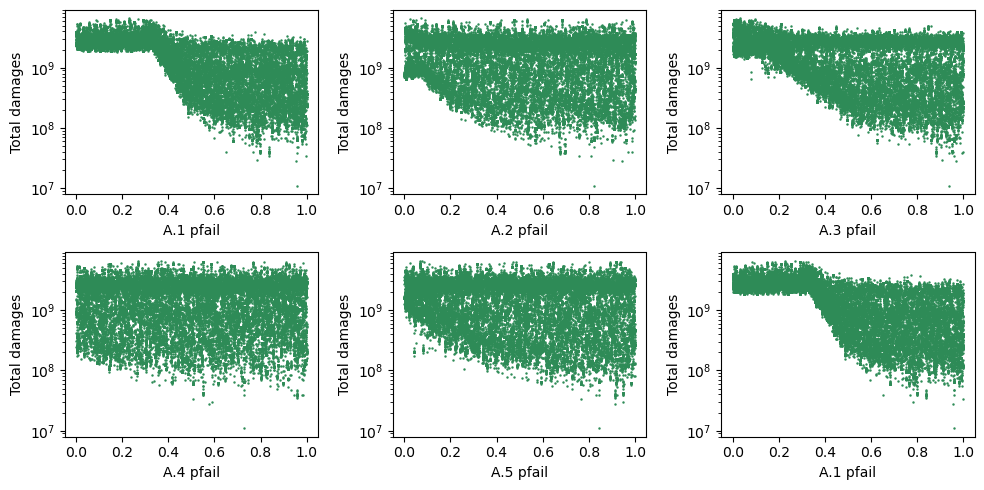

In [11]:
#Total damages vs the different pfails
rows = 2
cols = 3
fig, axs = plt.subplots(rows,cols, figsize = (10,5))
for i in range(rows*cols):
    axs[int(np.floor(i/(cols))),int(i%cols)].set_yscale("log")
    if i != rows*cols-1:
        axs[int(np.floor(i/cols)),int(i%cols)].plot(experiments[rings[i]+uncertainty],total_damages, linestyle = "none" ,marker = ".", color = "seagreen", markersize = 1.5)
        
        axs[int(np.floor(i/cols)),int(i%cols)].set_xlabel(rings[i]+" "+uncertainty[1:])
        axs[int(np.floor(i/cols)),int(i%cols)].set_ylabel("Total damages")
        
    else:
        axs[1,2].plot(experiments[rings[0]+uncertainty],total_damages, linestyle = "none" ,marker = ".", color = "seagreen", markersize =1.5)
        axs[1,2].set_xlabel("A.1 pfail")
        axs[1,2].set_ylabel("Total damages")
    

plt.tight_layout()
plt.show()

<class 'int'>


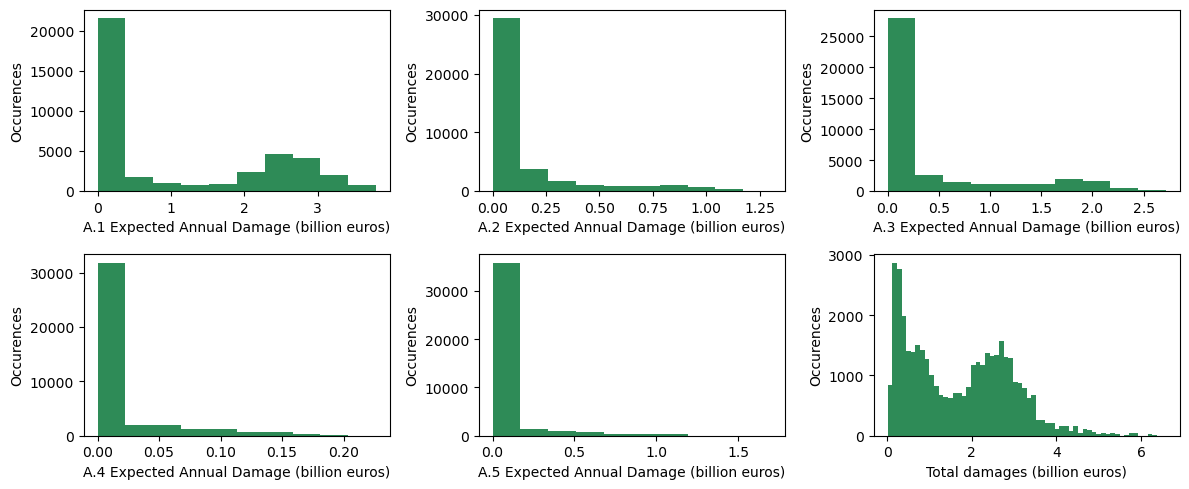

In [13]:
scale = 1e9
rows = 2
cols = 3
fig, axs = plt.subplots(rows,cols, figsize = (12,5))

for i in range(rows*cols):
    if i != rows*cols-1:
        axs[int(np.floor(i/cols)),int(i%cols)].hist(
                                             outcomes[rings[i]+outcome]/scale, color = "seagreen", bins = 10)
        axs[int(np.floor(i/cols)),int(i%cols)].set_ylabel("Occurences")
        axs[int(np.floor(i/cols)),int(i%cols)].set_xlabel(rings[i]+" "+outcome[1:]+ " (billion euros)")
        
    else:
        axs[rows-1,cols-1].hist(total_damages/scale, color = "seagreen", bins = 60)
        axs[rows-1,cols-1].set_xlabel("Total damages (billion euros)")
        axs[rows-1,cols-1].set_ylabel("Occurences")
    

plt.tight_layout()
plt.show()

0,0
1,0
2,0
0,1
1,1
2,1


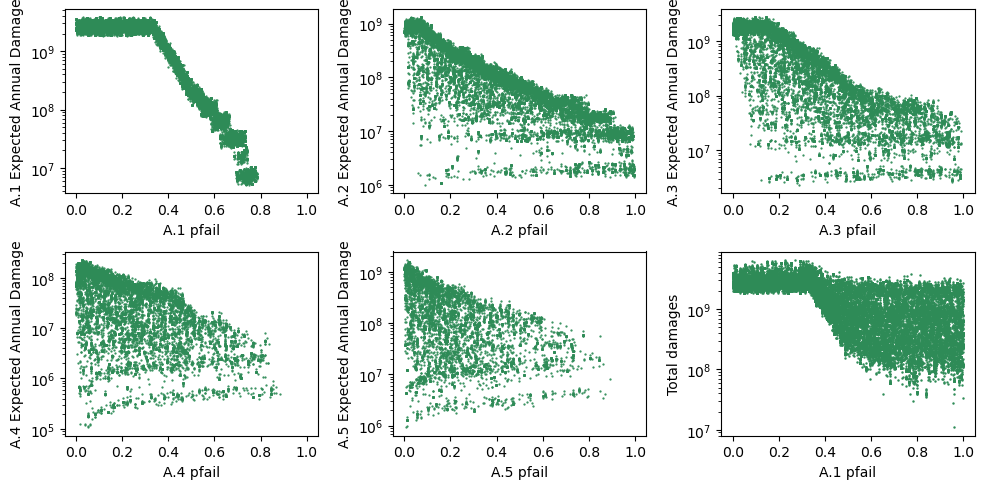

In [59]:
fig, axs = plt.subplots(2,3, figsize = (10,5))

for i in range(rows*cols):

    axs[int(np.floor(i/3)),int(i%3)].set_yscale("log")
    if i != rows*cols-1:
        axs[int(np.floor(i/cols)),int(i%cols)].scatter(experiments[rings[i]+uncertainty], 
                                             outcomes[rings[i]+outcome], marker = ".", c = "seagreen", s =1.5)
        total_damages += outcomes[rings[i]+outcome]
        axs[int(np.floor(i/cols)),int(i%cols)].set_xlabel(rings[i]+" "+uncertainty[1:])
        axs[int(np.floor(i/cols)),int(i%cols)].set_ylabel(rings[i]+" "+outcome[1:])
        
    else:
        axs[1,2].plot(experiments[rings[0]+uncertainty],total_damages, linestyle = "none" ,marker = ".", color = "seagreen", markersize =1.5)
        axs[1,2].set_xlabel("A.1 pfail")
        axs[1,2].set_ylabel("Total damages")
    

plt.tight_layout()
plt.show()

### Work in progress from here

In [14]:
# SCENARIO DISCOVERY
# WORK IN PROGRESS
from ema_workbench.analysis import prim

x = experiments.drop(labels=[l.name for l in dike_model.levers], axis=1)

outcomes_of_interest = outcomes['A.1_Expected Annual Damage']
y = outcomes_of_interest > np.percentile(outcomes_of_interest, 10)

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 40000 points remaining, containing 30624 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.656, coverage: 0.8568443051201672, density: 1.0 restricted_dimensions: 1


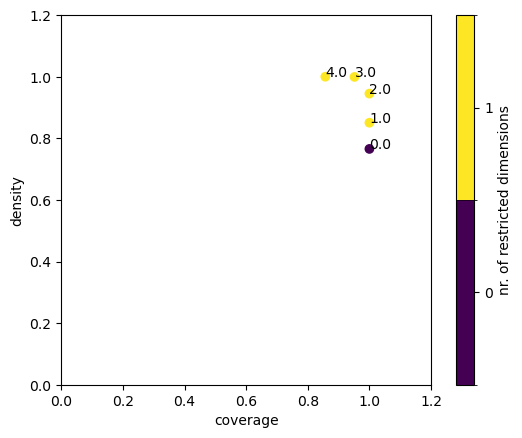

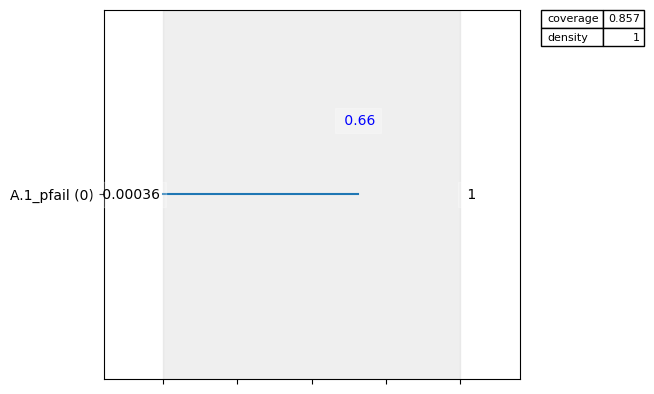

IndexError: single positional indexer is out-of-bounds

In [16]:
box1.show_tradeoff(annotated=True)
plt.show()

box1.inspect(style='graph')
plt.show()

box1.inspect(7)

box1.resample(7)

In [14]:
# only works because we have scalar outcomes
data = pd.DataFrame(outcomes)


In [23]:
strings = ["_Expected Annual Damage", "_Expected Number of Deaths", " Total Costs"]
for i in range(len(rings)):
    print(f"outcome for {rings[i]}{strings[0]}")
    y = outcomes[f'{rings[i]}{strings[0]}']
    problem = get_SALib_problem(dike_model.uncertainties)
    Si = sobol.analyze(problem, y, calc_second_order=True, print_to_console=True)

outcome for A.1_Expected Annual Damage


RuntimeError: 
        Incorrect number of samples in model output file.
        Confirm that calc_second_order matches option used during sampling.

In [16]:
# defining specific policies
# for example, policy 1 is about extra protection in upper boundary
# policy 2 is about extra protection in lower boundary
# policy 3 is extra protection in random locations


def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [
    Policy(
        "policy 1",
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 1, "0_RfR 1": 1, "0_RfR 2": 1, "A.1_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "policy 2",
        **dict(
            get_do_nothing_dict(),
            **{"4_RfR 0": 1, "4_RfR 1": 1, "4_RfR 2": 1, "A.5_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "policy 3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "2_RfR 1": 1, "3_RfR 2": 1, "A.3_DikeIncrease 0": 5}
        )
    ),
]